Test GenerateRefData class on getting the contour of the reference centerline

In [22]:
import sys
sys.path.append('..')

import numpy as np
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
import cv2
import matplotlib.pyplot as plt
import skimage.morphology as skimage_morphology
import torch

#### Read and process the ground truth image

In [23]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

Text(0.5, 1.0, 'Processed Ground Truth Image')

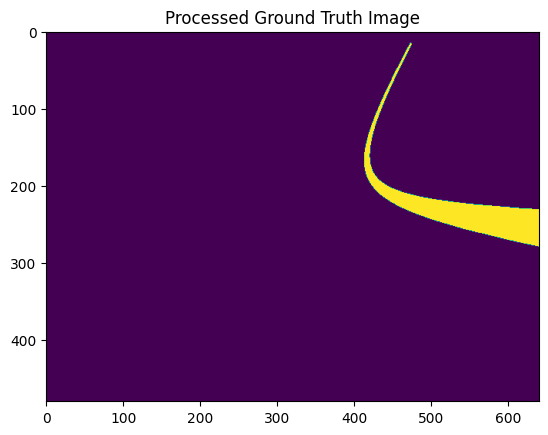

In [24]:
# case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset/gt_4_0.0006_0.0005_0.2_0.01'
case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_gt_6'
img_save_path = case_naming + '.png'

img_ref_binary = process_image(img_save_path)

plt.imshow(img_ref_binary)
plt.title('Processed Ground Truth Image')

#### Test the tip and base of the reference centerline

From test_loss_define_v2.py, GenerateRefData

In [25]:
def get_raw_centerline(img_ref):
        '''
        Method to get the raw centerline of the catheter from the reference image.
        '''
        img_height = img_ref.shape[0]
        img_width = img_ref.shape[1]

        # perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
        extend_dim = int(60)
        img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
        img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

        # get the left boundary of the image
        left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
        left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

        # get the center of the left boundary
        extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
        extend_vec_pt2_center = np.array(
            [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
        exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

        # avoid dividing by zero
        if exten_vec[1] == 0:
            exten_vec[1] += 0.00000001

        # get the slope and intercept of the line
        k_extend = exten_vec[0] / exten_vec[1]
        b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
        b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

        # extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
        # then it could be able to get the intersection point with boundary
        extend_ROI = np.array([
            np.array([img_width, left_boundarylineA_id[0]]),
            np.array([img_width, left_boundarylineA_id[-1]]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_up) / k_extend)])
        ])

        # fill the extended ROI with 1
        img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

        # skeletonize the image
        skeleton = skimage_morphology.skeletonize(img_thresh_extend)

        # get the centerline of the image
        img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

        return torch.as_tensor(img_raw_skeleton).float()

From test_loss_define_v2.py, TipDistanceLoss.

Be careful with the selection of tip and base on the centerline

In [26]:
def find_tip(ref_catheter_skeleton):
    img_raw_skeleton = ref_catheter_skeleton.flip(1)
    
    ref_skeleton_tip_point = img_raw_skeleton[0, :] # tip
    ref_skeleton_base_point = img_raw_skeleton[-1, :] # base
    return ref_skeleton_tip_point, ref_skeleton_base_point

In [27]:
img_raw_skeleton = get_raw_centerline(img_ref_binary)
img_raw_skeleton_np = img_raw_skeleton.flip(1).numpy()
ref_skeleton_tip_point, ref_skeleton_base_point = find_tip(img_raw_skeleton)
print(ref_skeleton_tip_point)

tensor([473.,  17.])


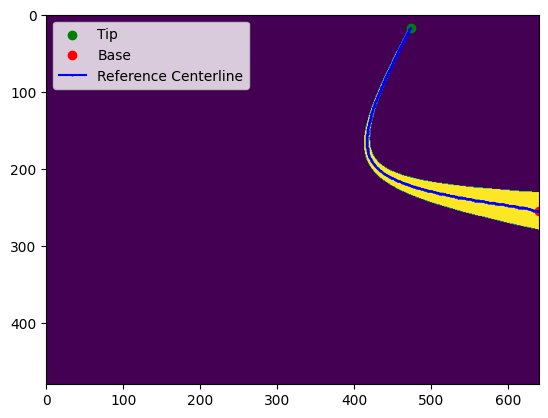

In [28]:
tip_coords = ref_skeleton_tip_point.numpy().astype(int)
base_coords = ref_skeleton_base_point.numpy().astype(int)

x = img_raw_skeleton_np[:, 0]
y = img_raw_skeleton_np[:, 1]

# Display the image using matplotlib
plt.imshow(img_ref_binary)
plt.scatter(tip_coords[0], tip_coords[1], color='green', label='Tip')  
plt.scatter(base_coords[0], base_coords[1], color='red', label='Base')
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Reference Centerline', markersize=0.5)
plt.legend()
plt.show()